In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from transformers import RobertaTokenizer, RobertaModel
from datasets import Dataset
import torch
import torch.nn as nn
from tqdm import tqdm
!pip install --quiet bertopic
!pip install --quiet sentence-transformers
!pip install --quiet keybert

# import warnings
# warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-06-21 10:57:26.501912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750503446.696065      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750503446.749654      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.4 MB/s eta 0:00:00
/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/test_sent_emo.csv
/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/dev_sent_emo.csv
/kaggle/input/roberta_finetuned_meld/pytorch/fi

In [2]:
# Path to CSVs
train_df = pd.read_csv('/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/train_sent_emo.csv')
dev_df = pd.read_csv('/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/dev_sent_emo.csv')
test_df = pd.read_csv('/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/test_sent_emo.csv')
# print(train_df.columns)
# train_df.head()



In [3]:
model = RobertaModel.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_length = tokenizer.model_max_length

def build_dynamic_context_inputs(df):
    inputs = []
    labels = []

    for dialog_id in df['Dialogue_ID'].unique():
        dialog = df[df['Dialogue_ID'] == dialog_id].sort_values('Utterance_ID')
        utterances = dialog['Utterance'].tolist()
        speakers = dialog['Speaker'].tolist()
        emotions = dialog['Emotion'].tolist()

        # Create speaker mapping for this dialogue
        unique_speakers = sorted(set(speakers))
        speaker_map = {name: f"speaker{i+1}" for i, name in enumerate(unique_speakers)}

        for idx in range(len(utterances)):
            context = []
            token_count = 0
            
            # Start from current utterance and go backward
            for i in range(idx, -1, -1):
                speaker_tag = speaker_map[speakers[i]]
                text_piece = f"{speaker_tag}: {utterances[i]}"
                tokens = tokenizer.tokenize(text_piece)
                token_count += len(tokens) + 1  # +1 for separator

                if token_count >= max_length:
                    break

                context.insert(0, text_piece)  # prepend so order is preserved

            input_text = " </s> ".join(context)
            inputs.append(input_text)
            labels.append(emotions[idx])

    return inputs, labels

train_inputs, train_labels = build_dynamic_context_inputs(train_df)
test_inputs, test_labels = build_dynamic_context_inputs(test_df)
dev_inputs, dev_labels = build_dynamic_context_inputs(dev_df)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:

# Build new DataFrame from contextual inputs
label2id = {label: i for i, label in enumerate(sorted(set(train_labels)))} # Dict that maps each label to an integer
encoded_labels = [label2id[label] for label in train_labels]

# Now create the dataframe
data_dict = {
    "text": train_inputs,
    "label": encoded_labels
}
context_df = pd.DataFrame(data_dict)
train_dataset = Dataset.from_pandas(context_df)

# Function to tokenize the batch
def tokenize_batch(batch):
    return tokenizer(batch['text'],
                     padding='max_length',
                     truncation=True,
                     max_length=512,
                     return_attention_mask=True)

# Apply tokenizer
train_tokenized = train_dataset.map(tokenize_batch, batched=True, batch_size=32)

# Prepare for PyTorch
train_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Sanity check
print(train_tokenized[0].keys())


# Now for the test set
test_label2id = {label: i for i, label in enumerate(sorted(set(test_labels)))} # Dict that maps each label to an integer
test_encoded_labels = [test_label2id[label] for label in test_labels]
test_data_dict = {
    "text": test_inputs,
    "label": test_encoded_labels
}
context_df = pd.DataFrame(test_data_dict)
test_dataset = Dataset.from_pandas(context_df)
test_tokenized = test_dataset.map(tokenize_batch, batched=True, batch_size=32)
test_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# dev set
dev_label2id = {label: i for i, label in enumerate(sorted(set(dev_labels)))} # Dict that maps each label to an integer
dev_encoded_labels = [dev_label2id[label] for label in dev_labels]
dev_data_dict = {
    "text": dev_inputs,
    "label": dev_encoded_labels
}
context_df = pd.DataFrame(dev_data_dict)
dev_dataset = Dataset.from_pandas(context_df)
dev_tokenized = dev_dataset.map(tokenize_batch, batched=True, batch_size=32)
dev_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


# Create dataloaders for train and dev sets (and maybe also test set)
from torch.utils.data import DataLoader
train_loader = DataLoader(train_tokenized, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_tokenized, batch_size=16)
test_loader = DataLoader(test_tokenized, batch_size=16)

Map:   0%|          | 0/9989 [00:00<?, ? examples/s]

dict_keys(['label', 'input_ids', 'attention_mask'])


Map:   0%|          | 0/2610 [00:00<?, ? examples/s]

Map:   0%|          | 0/1109 [00:00<?, ? examples/s]

In [5]:

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last 2 layers of the encoder
for layer in model.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

# Define classification head
class RobertaForEmotionClassification(nn.Module):
    def __init__(self, model, num_labels):
        super().__init__()
        self.roberta = model
        self.dropout = nn.Dropout(p=0.1)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

# Instantiate model
num_labels = len(set(train_labels))  # e.g. 7 emotions
Full_model = RobertaForEmotionClassification(model, num_labels)


In [6]:
# Load the trained model for F1 score
model_path = "/kaggle/input/roberta_finetuned_meld/pytorch/fine-tuned_1/1/best_emotion_model_5.pt"
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

base_model = RobertaModel.from_pretrained("roberta-base")
Full_model = RobertaForEmotionClassification(base_model, num_labels)
Full_model.load_state_dict(checkpoint['model_state_dict'])
Full_model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForEmotionClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
          

In [7]:
# Finally we get to the Topic Modelling
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Full_model.to(device)
Full_model.eval()

all_embeddings = []

with torch.no_grad():
    for loader in [train_loader]:
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = Full_model.roberta(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeds = outputs.last_hidden_state[:, 0, :]  # CLS token

            all_embeddings.append(cls_embeds.cpu())

# Combine all embeddings safely
embeddings_np = torch.cat(all_embeddings, dim=0).numpy()


100%|██████████| 625/625 [02:31<00:00,  4.11it/s]


In [8]:
import re
def remove_speaker_prefix(example):
    example['text'] = re.sub(r'speaker\d+:', '', example['text'], flags=re.IGNORECASE).strip()
    return example
test_dataset2 = test_dataset.map(remove_speaker_prefix)

Map:   0%|          | 0/2610 [00:00<?, ? examples/s]

In [9]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load a pre-trained model for sentence embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and effective

# Replace this with your list of utterances
sentences = test_dataset2['text']

# Generate embeddings
embeddings = model.encode(sentences, show_progress_bar=True)


from sklearn.decomposition import PCA
pca = PCA(n_components=50)
embeddings_reduced = pca.fit_transform(embeddings)


from sklearn.cluster import KMeans
num_topics = 7  # You can tune this
kmeans = KMeans(n_clusters=num_topics, random_state=42)
clusters = kmeans.fit_predict(embeddings_reduced)

from collections import defaultdict
import pandas as pd
cluster_to_sentences = defaultdict(list)
for sent, cluster_id in zip(sentences, clusters):
    cluster_to_sentences[cluster_id].append(sent)

# View example clusters
for cluster_id, utts in cluster_to_sentences.items():
    print(f"\nCluster {cluster_id} (Top 5 sentences):")
    for utt in utts[:5]:
        print("-", utt)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/82 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Cluster 1 (Top 5 sentences):
- Why do all youre coffee mugs have numbers on the bottom?
- Oh, okay, I get it.
- Ohh!
- Ohh! </s>  What? </s>  It kicked! I think the baby kicked!
- Ohh! </s>  What? </s>  It kicked! I think the baby kicked! </s>  Oh my God!

Cluster 6 (Top 5 sentences):
- Why do all youre coffee mugs have numbers on the bottom? </s>  Oh. Thats so Monica can keep track. That way if one on them is missing, she can be like, Wheres number 27?!
- Why do all youre coffee mugs have numbers on the bottom? </s>  Oh. Thats so Monica can keep track. That way if one on them is missing, she can be like, Wheres number 27?! </s>  Y'know what?
- Okay. </s>  Ross, didn't you say that there was an elevator in here?
- Okay. </s>  Ross, didn't you say that there was an elevator in here? </s>  Uhh, yes I did but there isn't. Okay, here we go.
- Okay. </s>  Ross, didn't you say that there was an elevator in here? </s>  Uhh, yes I did but there isn't. Okay, here we go. </s>  Okay, 

In [10]:
# For the extraction of keywords
from keybert import KeyBERT
kw_model = KeyBERT(model=model)  # reuse your sentence-transformer

for cluster_id, texts in cluster_to_sentences.items():
    doc = " ".join(texts)
    keywords = kw_model.extract_keywords(doc, top_n=5)
    print(f"Cluster {cluster_id}: {keywords}")

Cluster 1: [('kicked', 0.3769), ('underwear', 0.3128), ('boots', 0.3104), ('crotch', 0.3035), ('kick', 0.3031)]
Cluster 6: [('elevator', 0.3764), ('ross', 0.2979), ('mugs', 0.2974), ('monica', 0.2913), ('missing', 0.274)]
Cluster 2: [('lydia', 0.4043), ('push', 0.3985), ('pull', 0.3716), ('pushing', 0.3703), ('jam', 0.3429)]
Cluster 5: [('howard', 0.5171), ('bob', 0.3032), ('tim', 0.2386), ('david', 0.2329), ('guy', 0.2235)]
Cluster 0: [('chandler', 0.4801), ('room', 0.3828), ('joey', 0.328), ('phoebe', 0.3189), ('chan', 0.2929)]
Cluster 4: [('damage', 0.3868), ('bedroom', 0.3086), ('room', 0.302), ('bedrooms', 0.2929), ('uniform', 0.2872)]
Cluster 3: [('couple', 0.2713), ('fight', 0.2599), ('fighting', 0.2541), ('relationship', 0.2317), ('stay', 0.2301)]


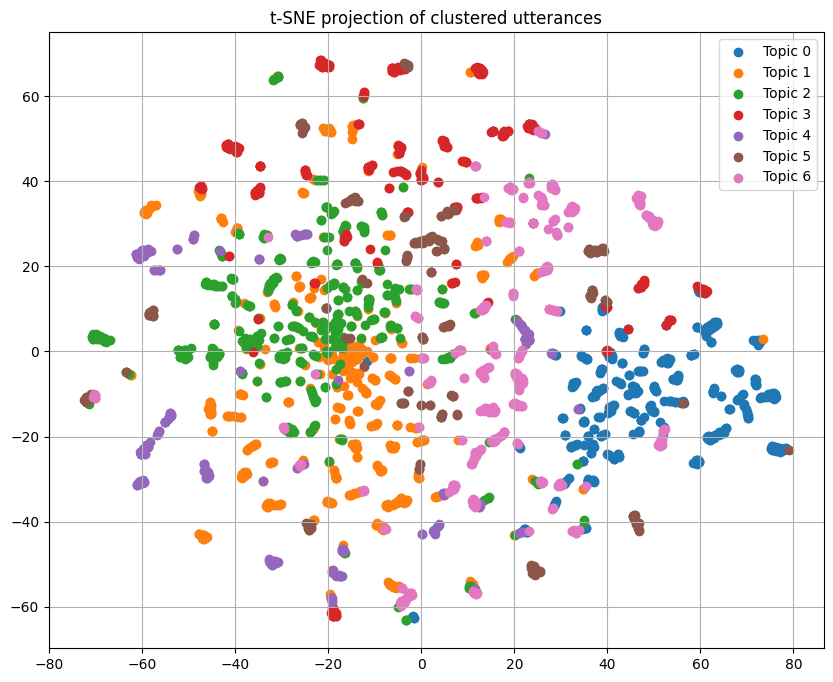

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings_reduced)  # `embeddings_reduced` = PCA-reduced version

# Plot clusters
plt.figure(figsize=(10, 8))
for i in range(num_topics):  # or `n_clusters` if you're using KMeans
    plt.scatter(tsne_embeddings[clusters == i, 0], tsne_embeddings[clusters == i, 1], label=f"Topic {i}")

plt.legend()
plt.title("t-SNE projection of clustered utterances")
plt.grid(True)
plt.show()